In [1]:
import pandas as pd
import numpy as np
from osgeo import gdal, osr
from pyproj import Proj, transform
import rasterio as rio
from rasterio.transform import from_origin
import math
from scipy.interpolate import griddata
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('../Model_Data_Patton_DATED/Barnes_eemian5_WGS_extract/Alta/Alta_B3C__2500_WGS.csv', header=None, names=['x','y','z'])

In [3]:
print(data)

           x        y       z
0    23.1009  67.5428  2171.0
1    23.2499  67.6128  2163.0
2    23.3999  67.6826  2154.0
3    23.5508  67.7523  2144.0
4    23.7026  67.8217  2134.0
..       ...      ...     ...
801  22.4602  70.8289   687.0
802  22.6323  70.8992   625.0
803  22.8056  70.9693   563.0
804  22.9801  71.0391   508.0
805  23.1560  71.1088   455.0

[806 rows x 3 columns]


In [4]:
npdata = data.to_numpy()
#print(npdata[:,2]) - z column
len(npdata[:,2])

806

In [5]:
#reshape into array 31across by 26 vert
rsLON = np.reshape(npdata[:,0],(31,26)) #LON
rsLAT = np.reshape(npdata[:,1],(31,26)) #LAT
rsz = np.reshape(npdata[:,2],(31,26))   #DATA

In [6]:
# flip rsz
rsz = np.flip(rsz, axis=1)
rsz = np.flip(rsz, axis=0)
#rsz = np.flip(rsz, axis=1)

In [7]:
# Show three pandas dataframes - one for each value
dfLON = pd.DataFrame(rsLON) # LONGITUDE
dfLAT = pd.DataFrame(rsLAT) # LATITUDE
dfz = pd.DataFrame(rsz)     # Z VALUE

In [8]:
xmin,ymin,xmax,ymax = [rsLON.min(),rsLAT.min(),rsLON.max(),rsLAT.max()]
print(xmin, ymin, xmax, ymax)

18.3948 67.5428 28.0 71.1088


In [9]:
# Create new matrix
NLON = np.linspace(xmin, xmax, math.ceil(10/0.16))
NLAT = np.linspace(ymin, ymax, math.ceil(6/0.067))
LonCo, LatCo = np.meshgrid(NLON, NLAT)
LONflat = rsLON.flatten()
LATflat = rsLAT.flatten()

In [10]:
pts_arr = np.array([LONflat, LATflat]).T
#pts_arr = np.array(rsLON, rsLAT)

In [11]:
# Scipy Griddata function
out_tiff = griddata(pts_arr, rsz.flatten(), (LonCo, LatCo), method='nearest')
out_tiff = np.flip(out_tiff, axis=1)

In [12]:
OT = pd.DataFrame(out_tiff)
print(OT)

        0       1       2       3       4       5       6       7       8   \
0   1084.0  1082.0  1082.0  1097.0  1113.0  1136.0  1141.0  1141.0  1129.0   
1   1084.0  1084.0  1082.0  1097.0  1113.0  1136.0  1141.0  1141.0  1129.0   
2   1084.0  1084.0  1082.0  1097.0  1113.0  1136.0  1136.0  1141.0  1129.0   
3   1084.0  1084.0  1082.0  1097.0  1113.0  1136.0  1136.0  1141.0  1129.0   
4   1110.0  1084.0  1082.0  1097.0  1113.0  1113.0  1136.0  1141.0  1129.0   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
85  1252.0  1352.0  1477.0  1567.0  1567.0  1625.0  1684.0  1747.0  1747.0   
86  1252.0  1352.0  1477.0  1567.0  1567.0  1625.0  1684.0  1747.0  1747.0   
87  1352.0  1352.0  1477.0  1567.0  1567.0  1625.0  1684.0  1747.0  1747.0   
88  1352.0  1352.0  1477.0  1567.0  1625.0  1625.0  1684.0  1747.0  1747.0   
89  1352.0  1352.0  1477.0  1567.0  1625.0  1625.0  1684.0  1747.0  1802.0   

        9   ...      53      54      55      56      57      58

### NEEDS EDITING

In [13]:
# For each pixel I know it's latitude and longitude.
# As you'll see below you only really need the coordinates of
# one corner, and the resolution of the file.

xmin,ymin,xmax,ymax = [LONflat.min(),LATflat.min(),LONflat.max(),LATflat.max()]
nrows,ncols = np.shape(out_tiff)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin,xres,0,ymax,0,-yres)   
# That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
#         top left y, rotation (0 if North is up), n-s pixel resolution)
# I don't know why rotation is in twice???

In [14]:
#Writing 
output_raster = gdal.GetDriverByName('GTiff').Create('../Orientation_Proof_of_Concept/Alta_Rasters/Alta_B3C__2500_WGS.tif',ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
output_raster.GetRasterBand(1).WriteArray(rsz)   # Writes my array to the raster
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
                                           
output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
                                                   # to the file
output_raster.GetRasterBand(1).WriteArray(out_tiff)   # Writes my array to the raster

output_raster.FlushCache()

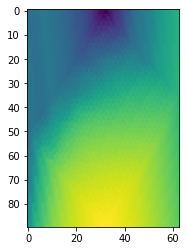

In [15]:
plt.imshow(out_tiff)